## S10 T01: Aprenentage Supervisat
## Luis Pardina - Data Science - 14/06/22

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

#classification models
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier

#classification metrics
from imblearn.metrics import sensitivity_score, specificity_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, recall_score
from sklearn.metrics import classification_report
from sklearn import metrics

#undersampling, oversampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

#hyperparameters setting and cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

### *Exercici 1*: Crea almenys tres models de classificació diferents per intentar predir el millor possible l’endarreriment dels vols (ArrDelay) de DelayedFlights.csv. Considera si el vol ha arribat tard o no (ArrDelay > 0).

I read and download the two csv files I created in the previous sprint, which contain a 10% representative sample of the flights dataset.

In [2]:
mostra_X = pd.read_csv('mostra_X.csv')
mostra_X.drop('Unnamed: 0', axis=1, inplace=True)
mostra_y = pd.read_csv('mostra_y.csv')
mostra_y.drop('Unnamed: 0', axis=1, inplace=True)

In [79]:
pd.set_option('display.max_columns', None)

Let's remember:
- the Year column was removed, 
- the cancelled and diverted flights were deleted.
- the CRSDepTime was transformed into a bin of 24 hours
- I added new columns:
    - Month, DayofWeek and CRSDepTime **normalized**
    - Actual Elapsed Time, CRS Elapsed Time, AirTime, DepDelay, Distance, Taxi In, Taxi Out **standardized**
    - Unique Carrier **dumified**
- I will not use for the exercise the columns CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay since they are a split of causes of the ArrDelay (the sum of those equals ArrDelay).

In [80]:
mostra_X

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,norm_Month,norm_DayOfWeek,norm_CRSDepTime,9E,AA,AQ,AS,B6,CO,DL,EV,F9,FL,HA,MQ,NW,OH,OO,UA,US,WN,XE,YV,stand_ActualElapsedTime,stand_CRSElapsedTime,stand_AirTime,stand_Distance,stand_DepDelay,stand_TaxiIn,stand_TaxiOut
0,8,22,5,1613.0,14,1808.0,1630,B6,1075,N290JB,115.0,91.0,49.0,74.0,JFK,RIC,288,3.0,63.0,4.0,0.0,24.0,0.0,70.0,0.636364,0.666667,0.608696,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.011765,-0.301205,-0.5125,-0.481818,1.219512,-0.75,4.454545
1,12,29,1,2211.0,21,2221.0,2158,EV,5668,N981EV,70.0,83.0,54.0,36.0,ATL,EVV,350,2.0,14.0,5.0,0.0,0.0,0.0,18.0,1.000000,0.000000,0.913043,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.541176,-0.397590,-0.4500,-0.387879,0.292683,-1.00,0.000000
2,8,7,4,946.0,9,1313.0,1301,UA,177,N576UA,387.0,387.0,358.0,12.0,BOS,SFO,2704,9.0,20.0,NaN,NaN,NaN,NaN,NaN,0.636364,0.500000,0.391304,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3.188235,3.265060,3.3500,3.178788,-0.292683,0.75,0.545455
3,5,13,2,842.0,8,1156.0,1125,WN,2877,N616SW,194.0,180.0,184.0,17.0,PHX,SEA,1107,4.0,6.0,0.0,0.0,14.0,0.0,17.0,0.363636,0.166667,0.347826,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.917647,0.771084,1.1750,0.759091,-0.170732,-0.50,-0.727273
4,3,10,1,929.0,8,1145.0,1058,9E,2966,88009E,136.0,158.0,113.0,69.0,BGR,DTW,750,9.0,14.0,47.0,0.0,0.0,0.0,0.0,0.181818,0.000000,0.347826,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.235294,0.506024,0.2875,0.218182,1.097561,0.75,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192833,3,18,2,1418.0,14,1632.0,1607,XE,2995,N41104,194.0,187.0,178.0,18.0,EWR,MSP,1008,4.0,12.0,0.0,0.0,7.0,0.0,18.0,0.181818,0.166667,0.608696,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.917647,0.855422,1.1000,0.609091,-0.146341,-0.50,-0.181818
192834,1,23,3,1347.0,13,1609.0,1615,WN,331,N311SW,142.0,165.0,131.0,17.0,MCO,CLE,895,4.0,7.0,NaN,NaN,NaN,NaN,NaN,0.000000,0.333333,0.565217,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.305882,0.590361,0.5125,0.437879,-0.170732,-0.50,-0.636364
192835,4,10,4,2205.0,21,2349.0,2325,AA,1509,N5DMAA,224.0,230.0,197.0,30.0,ORD,LAS,1515,7.0,20.0,0.0,0.0,24.0,0.0,0.0,0.272727,0.500000,0.913043,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.270588,1.373494,1.3375,1.377273,0.146341,0.25,0.545455
192836,1,6,7,1258.0,12,1401.0,1310,MQ,3338,N263AE,63.0,55.0,30.0,43.0,TYR,DFW,103,19.0,14.0,0.0,0.0,8.0,0.0,43.0,0.000000,1.000000,0.521739,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-0.623529,-0.734940,-0.7500,-0.762121,0.463415,3.25,0.000000


First, I'll convert the column 'ArrDelay' of mostra_y to create two classes:

    0: Fligth on time on Arrival, ArrDelay <= 0
    1: Flight delayed on Arrival, ArrDelay > 0

In [3]:
mostra_y['ArrDelay'] = mostra_y['ArrDelay'].apply(lambda x : 0 if x <= 0 else 1)

Data is unbalanced, which a huge proportion (89%) of delays (1):

In [4]:
mostra_y.value_counts(normalize=True)

ArrDelay
1           0.894414
0           0.105586
dtype: float64

I start the analysis with the 8 variables that showed more correlation with the Arrival Delay in the previous sprint. CRSDepTime has been converted into 24 bins (for the 24 hours of the day).

In [6]:
first_set_of_var = ['Month','DayOfWeek', 'CRSDepTime', 'Distance', 'AirTime','DepDelay', 'TaxiOut', 'TaxiIn']

In [7]:
raw = mostra_X[first_set_of_var]

In [8]:
round(raw.describe(),1)

,Month,DayOfWeek,CRSDepTime,Distance,AirTime,DepDelay,TaxiOut,TaxiIn
count,192838.0,192838.0,192838.0,192838.0,192838.0,192838.0,192838.0,192838.0
mean,6.1,4.0,14.4,765.3,108.4,43.0,18.2,6.8
std,3.5,2.0,4.3,573.5,68.7,52.5,14.3,5.3
min,1.0,1.0,0.0,30.0,0.0,6.0,0.0,0.0
25%,3.0,2.0,11.0,338.0,58.0,12.0,10.0,4.0
50%,6.0,4.0,15.0,606.0,90.0,24.0,14.0,6.0
75%,9.0,6.0,18.0,998.0,138.0,53.0,21.0,8.0
max,12.0,7.0,23.0,4962.0,637.0,1303.0,337.0,199.0


Generation of train and test subsets:

In [9]:
y = np.array(mostra_y)
X = np.array(raw)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)

LOGISTIC REGRESSION -> classifier1

In [10]:
classifier1 = LogisticRegression()
classifier1.fit(X_train, y_train);

XGBOOST -> classifier2

In [11]:
classifier2 = xgb.XGBClassifier()
classifier2.fit(X_train, y_train);

DECISION TREE -> classifier3

In [12]:
classifier3 = DecisionTreeClassifier()
classifier3.fit(X_train, y_train);

### *Exercici 2*: Compara els models de classificació utilitzant la precisió (accuracy), una matriu de confiança i d’altres mètriques més avançades.

I develop a function to generate the five more relevant metrics for classification models: accuracy, precision, sensitivity, specificity and f1:

In [49]:
def metrics (model, y, y_pred):
     return {'Model':model, 'Accuracy': accuracy_score(y, y_pred), 'Precision': precision_score(y, y_pred), 'Sensitivity': sensitivity_score(y, y_pred), 'Specificity': specificity_score(y, y_pred), 'f1 score': f1_score(y, y_pred)}

Now we see the metrics and the confusion matrix results for this model:

In [14]:
lr_y = classifier1.predict(X_test)

In [15]:
table = pd.DataFrame(metrics('Logistic Regression', y_test, lr_y),index=[0])
cm_lr = confusion_matrix(y_test, lr_y)

In [16]:
table

,Model,Accuracy,Precision,Sensitivity,Specificity,f1 score
0,Logistic Regression,0.903582,0.913172,0.985643,0.22484,0.948025


In [17]:
cm_lr

array([[ 1403,  4837],
       [  741, 50871]], dtype=int64)

***Conclusion***:
The **specificity** (22%) is very low, which indicates how poorly the model predicts the Negatives (flights without delay): it only hits 1403 out of 6240! And also, the accuracy (91%) is marginally higher than the mere percentage of Positives in the dataset (89%). In other words, it's almost as bad a model as predicting that all flights are delayed...

I consider a must to adjust the logistic regression model improving the predictions of negatives. For this, we have to rebalance the sample through **undersampling and/or oversampling**.

There are plenty of options to do undersampling. In this exercise, I will test the random under sampling and the SMOTE oversampling.

The sampling_strategy is a parameter which defines the ratio between the smaller and the bigger classes. I will test a couple of options, not to far of the true ratio 0.105586/0.894414 = 11.8%

The undesampling reduces the bigger class, the oversampling increases the smaller class.

In [20]:
rebalanced_options = pd.DataFrame(metrics('Logistic Regression', y_test, lr_y),index=[0])

In [21]:
print(X_train.shape, np.unique(y_train, return_counts=True))

(134986, 8) (array([0, 1], dtype=int64), array([ 14121, 120865], dtype=int64))


In [22]:
# two tests for undersampling, sampling strategy 15% and 25%    
under = RandomUnderSampler(sampling_strategy= 0.15) 
X_bl, y_bl = under.fit_resample(X_train, y_train)
print(X_bl.shape, 0.15, np.unique(y_bl, return_counts=True))
a =  LogisticRegression()   
a.fit(X_bl, y_bl)
lr_y_2 = a.predict(X_test)
rebalanced_options = rebalanced_options.append(metrics('Logistic Undersampled {x}%'.format(x=0.15), y_test, lr_y_2), ignore_index = True)
    
under = RandomUnderSampler(sampling_strategy= 0.25) 
X_bl, y_bl = under.fit_resample(X_train, y_train)
print(X_bl.shape, 0.25, np.unique(y_bl, return_counts=True))
b =  LogisticRegression()   
b.fit(X_bl, y_bl)
lr_y_2 = b.predict(X_test)
rebalanced_options = rebalanced_options.append(metrics('Logistic Undersampled {x}%'.format(x=0.25), y_test, lr_y_2), ignore_index = True)    

# now two tests for oversampling, sampling strategy 15% and 25%
over = SMOTE(sampling_strategy= 0.15) 
X_bl, y_bl = over.fit_resample(X_train, y_train)
print(X_bl.shape, 0.15, np.unique(y_bl, return_counts=True))
c = LogisticRegression()
c.fit(X_bl, y_bl)
lr_y_2 = c.predict(X_test)
rebalanced_options = rebalanced_options.append(metrics('Logistic Oversampled {x}%'.format(x=0.15), y_test, lr_y_2), ignore_index = True)
    
over = SMOTE(sampling_strategy= 0.25) 
X_bl, y_bl = over.fit_resample(X_train, y_train)
print(X_bl.shape, 0.25, np.unique(y_bl, return_counts=True))
d = LogisticRegression()
d.fit(X_bl, y_bl)
lr_y_2 = d.predict(X_test)
rebalanced_options = rebalanced_options.append(metrics('Logistic Oversampled {x}%'.format(x=0.25), y_test, lr_y_2), ignore_index = True)
    

(108261, 8) 0.15 (array([0, 1], dtype=int64), array([14121, 94140], dtype=int64))
(70605, 8) 0.25 (array([0, 1], dtype=int64), array([14121, 56484], dtype=int64))
(138994, 8) 0.15 (array([0, 1], dtype=int64), array([ 18129, 120865], dtype=int64))
(151081, 8) 0.25 (array([0, 1], dtype=int64), array([ 30216, 120865], dtype=int64))


In [23]:
def show(table):
    return table.style.highlight_max(['Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'f1 score'])

In [24]:
show(rebalanced_options)

,Model,Accuracy,Precision,Sensitivity,Specificity,f1 score
0,Logistic Regression,0.903582,0.913172,0.985643,0.224840,0.948025
1,Logistic Undersampled 0.15%,0.905708,0.921856,0.977137,0.314904,0.948692
2,Logistic Undersampled 0.25%,0.899260,0.940858,0.946582,0.507853,0.943711
3,Logistic Oversampled 0.15%,0.905673,0.922209,0.976653,0.318590,0.948650
4,Logistic Oversampled 0.25%,0.899675,0.942077,0.945691,0.519071,0.943880


***Conclusion***:
The process to balance the dataset achieves the goal (as we can see by the drastic improvement of the Specificity from 22% to >50%). Also the Precision improves a bit, while Accuracy and Sensitivity are worsened a bit.

As an additional exercise I will test a combination of both techniques with the help of a pipeline.

I will also use for the other two models I selected this last *balanced* dataset, to compare the results.

In [25]:
over = SMOTE(sampling_strategy= 0.15)
under = RandomUnderSampler(sampling_strategy= 0.25) 

steps = [('o', over), ('u', under)]

pipeline = Pipeline(steps = steps)

X_bl, y_bl = pipeline.fit_resample(X_train, y_train)
print(X_bl.shape, 'o=0.15, u=0.25', np.unique(y_bl, return_counts=True))

(90645, 8) o=0.15, u=0.25 (array([0, 1], dtype=int64), array([18129, 72516], dtype=int64))


In [26]:
classifier1.fit(X_bl, y_bl)
e = LogisticRegression()
e.fit(X_bl, y_bl)
lr_y_2 = e.predict(X_test)
rebalanced_options = rebalanced_options.append(metrics('Logistic Over/Undersampled', y_test, lr_y_2), ignore_index = True)

In [27]:
show(rebalanced_options)

,Model,Accuracy,Precision,Sensitivity,Specificity,f1 score
0,Logistic Regression,0.903582,0.913172,0.985643,0.224840,0.948025
1,Logistic Undersampled 0.15%,0.905708,0.921856,0.977137,0.314904,0.948692
2,Logistic Undersampled 0.25%,0.899260,0.940858,0.946582,0.507853,0.943711
3,Logistic Oversampled 0.15%,0.905673,0.922209,0.976653,0.318590,0.948650
4,Logistic Oversampled 0.25%,0.899675,0.942077,0.945691,0.519071,0.943880
5,Logistic Over/Undersampled,0.899156,0.940648,0.946698,0.505929,0.943663


Now I continue with the train of the other two models. First the XGBoost, for the unbalanced (original) and balanced sets.

In [28]:
xgb_y = classifier2.predict(X_test)
cm_xgb = confusion_matrix(y_test, xgb_y)
cm_xgb

array([[ 2689,  3551],
       [ 1244, 50368]], dtype=int64)

In [29]:
classifier2_bl = xgb.XGBClassifier()
classifier2_bl.fit(X_bl, y_bl);
xgb_y_bl = classifier2_bl.predict(X_test)
cm_xgb_bl = confusion_matrix(y_test, xgb_y_bl)
cm_xgb_bl

array([[ 3789,  2451],
       [ 2692, 48920]], dtype=int64)

And finally the Decision Tree:

In [31]:
dtc_y = classifier3.predict(X_test)
cm_dtc = confusion_matrix(y_test, dtc_y)
cm_dtc

array([[ 2832,  3408],
       [ 3837, 47775]], dtype=int64)

In [32]:
classifier3_bl = DecisionTreeClassifier()
classifier3_bl.fit(X_bl, y_bl);
dtc_y_bl = classifier3_bl.predict(X_test)
cm_dtc_bl = confusion_matrix(y_test, dtc_y_bl)
cm_dtc_bl

array([[ 3367,  2873],
       [ 5389, 46223]], dtype=int64)

I show the metric results:

In [33]:
table = table.append(metrics('XGBoost', y_test, xgb_y), ignore_index = True)
table = table.append(metrics('Decision Tree', y_test, dtc_y), ignore_index = True)
table = table.append(metrics('Logistic Balanced', y_test, lr_y_2), ignore_index = True)
table = table.append(metrics('XGBoost Balanced', y_test, xgb_y_bl), ignore_index = True)
table = table.append(metrics('Decision Tree Balanced', y_test, dtc_y_bl), ignore_index = True)

In [34]:
show(table)

,Model,Accuracy,Precision,Sensitivity,Specificity,f1 score
0,Logistic Regression,0.903582,0.913172,0.985643,0.224840,0.948025
1,XGBoost,0.917116,0.934142,0.975897,0.430929,0.954563
2,Decision Tree,0.874767,0.933415,0.925657,0.453846,0.929520
3,Logistic Balanced,0.899156,0.940648,0.946698,0.505929,0.943663
4,XGBoost Balanced,0.911101,0.952288,0.947842,0.607212,0.950060
5,Decision Tree Balanced,0.857187,0.941482,0.895586,0.539583,0.917961


***Conclusion***:
There are relevant differences in the results of the metrics for the different models I selected: XGBoost shows a better performance if we evaluate all the metrics. Also, when the dataset is unbalanced as it was in this case, the use of undersampling/oversampling improves the overall performance for all the models. 

As a practical exercise I draw the ROC/AUC curve for the case of the XGBoost model trained over the balanced sample.

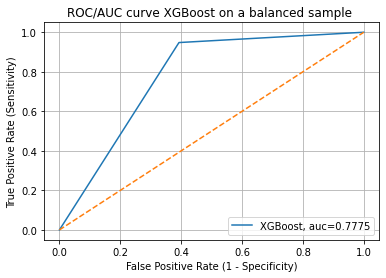

In [41]:
fpr, tpr, not_used = metrics.roc_curve(y_test, xgb_y_bl)
auc_xgb = metrics.roc_auc_score(y_test, xgb_y_bl)
plt.plot(fpr,tpr,label="XGBoost, auc="+str(round(auc_xgb, 4)))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.legend(loc=4)
plt.title('ROC/AUC curve XGBoost on a balanced sample '); 

### *Exercici 3*: Entrena’ls utilitzant els diferents paràmetres que admeten.

I will train the models with the help of GridSearch to identify the best hyperparameters. Just to keep separated the effects on the improvement of the metrics and to compare them, I will train the adjusted models over the original (unbalanced) train set. 

In [43]:
classifier1.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [44]:
#dictionary of search space
space = dict()
space['penalty'] = ['l2', 'l1','elasticnet']
space['max_iter'] = [100, 150]
space['solver'] = ['lbfgs', 'saga']

search = GridSearchCV(LogisticRegression(), space)

result = search.fit(X_train, y_train)

print('Best Hyperparameters: ', result.best_params_)

Best Hyperparameters:  {'max_iter': 150, 'penalty': 'l2', 'solver': 'lbfgs'}


In [45]:
classifier1_adj = LogisticRegression(max_iter= 150, penalty = 'l2', solver = 'lbfgs')

In [46]:
classifier1_adj.fit(X_train, y_train);
lr_y_adj = classifier1_adj.predict(X_test)
cm_lr_adj = confusion_matrix(y_test, lr_y_adj)
cm_lr_adj

array([[ 1348,  4892],
       [  681, 50931]], dtype=int64)

In [50]:
table = table.append(metrics('Logistic Adj', y_test, lr_y_adj), ignore_index = True)

In [51]:
classifier2.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [52]:
#dictionary of search space
space = dict()
space['booster'] = ['gbtree', 'dart' ]
space['max_depth'] = [6, 7]
space['tree_method'] = ['exact', 'gpu_hist']

search = GridSearchCV(xgb.XGBClassifier(), space)

result = search.fit(X_train, y_train)

print('Best Hyperparameters: ', result.best_params_)

Best Hyperparameters:  {'booster': 'gbtree', 'max_depth': 7, 'tree_method': 'exact'}


In [53]:
classifier2_adj = xgb.XGBClassifier(booster = 'gbtree', max_depth = 7, tree_method = 'exact')

In [54]:
classifier2_adj.fit(X_train, y_train);
xgb_y_adj = classifier2_adj.predict(X_test)
cm_xgb_adj = confusion_matrix(y_test, xgb_y_adj)
cm_xgb_adj

array([[ 2783,  3457],
       [ 1293, 50319]], dtype=int64)

In [55]:
table = table.append(metrics('XGBoost Adj', y_test, xgb_y_adj), ignore_index = True)

In [56]:
classifier3.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [57]:
#dictionary of search space
space = dict()
space['class_weight'] = [None, 'balanced' ]
space['criterion'] = ['gini', 'entropy', 'log_loss']

search = GridSearchCV(DecisionTreeClassifier(), space)

result = search.fit(X_train, y_train)

print('Best Hyperparameters: ', result.best_params_)

Best Hyperparameters:  {'class_weight': 'balanced', 'criterion': 'entropy'}


In [59]:
classifier3_adj = DecisionTreeClassifier(class_weight = 'balanced', criterion = 'entropy')

In [60]:
classifier3_adj.fit(X_train, y_train);
dtc_y_adj = classifier3_adj.predict(X_test)
cm_dtc_adj = confusion_matrix(y_test, dtc_y_adj)
cm_dtc_adj

array([[ 2661,  3579],
       [ 3290, 48322]], dtype=int64)

In [61]:
table = table.append(metrics('Decision Tree Adj', y_test, dtc_y_adj), ignore_index = True)

In [62]:
show(table)

,Model,Accuracy,Precision,Sensitivity,Specificity,f1 score
0,Logistic Regression,0.903582,0.913172,0.985643,0.224840,0.948025
1,XGBoost,0.917116,0.934142,0.975897,0.430929,0.954563
2,Decision Tree,0.874767,0.933415,0.925657,0.453846,0.929520
3,Logistic Balanced,0.899156,0.940648,0.946698,0.505929,0.943663
4,XGBoost Balanced,0.911101,0.952288,0.947842,0.607212,0.950060
5,Decision Tree Balanced,0.857187,0.941482,0.895586,0.539583,0.917961
6,Logistic Adj,0.903668,0.912366,0.986805,0.216026,0.948127
7,XGBoost Adj,0.917894,0.935715,0.974948,0.445994,0.954928
8,Decision Tree Adj,0.881266,0.931042,0.936255,0.426442,0.933641


***Conclusion***:
The adjustment of the hyperparameters improves the performance of the models, but (at least for the ones I selected) it is not as good as balancing the dataset to achieve a better specificity.

### *Exercici 4*: Compara el seu rendiment utilitzant l’aproximació traint/test o cross-validation.

***Conclusion***:
The cross validation ofers very similar results to the train/test approach (I select the f1 metric for the comparison). Probably this is because the number of samples is big enough.

In [64]:
# apply cross validation for f1
f1_cv_lr = cross_val_score(classifier1_adj, X, y, scoring = "f1")
f1_cv_xgb = cross_val_score(classifier2_adj, X, y, scoring = "f1")
f1_cv_dtb = cross_val_score(classifier3_adj, X, y, scoring = "f1")

In [65]:
f1_cv_lr

array([0.94837503, 0.94898772, 0.94937771, 0.95171173, 0.94930876])

In [66]:
print('Cross Validation Logistic Regression: average {a}, standardard deviation {b}'.format(a = np.mean(f1_cv_lr), b= np.std(f1_cv_lr)))

Cross Validation Logistic Regression: average 0.9495521887101299, standardard deviation 0.001136456234914638


In [67]:
f1_cv_xgb

array([0.95535017, 0.95652421, 0.95566097, 0.95521795, 0.95558967])

In [68]:
print('Cross Validation XGBoost: average {a}, standardard deviation {b}'.format(a = np.mean(f1_cv_xgb), b= np.std(f1_cv_xgb)))

Cross Validation XGBoost: average 0.9556685935395395, standardard deviation 0.0004566924592892049


In [69]:
f1_cv_dtb

array([0.9353599 , 0.93430382, 0.93411251, 0.93413659, 0.93502285])

In [70]:
print('Cross Validation Decision Tree: average {a}, standardard deviation {b}'.format(a = np.mean(f1_cv_dtb), b= np.std(f1_cv_dtb)))

Cross Validation Decision Tree: average 0.934587135342969, standardard deviation 0.0005090264918386634


### *Exercici 5*: Realitza algun procés d’enginyeria de variables per millorar-ne la predicció.

I use the same quantitative variables than before, but I have normalized month, day of week and scheduled departure time, and I have standardized with Robust Scaler AirTime, Distance, DepDelay, TaxiIn and TaxiOut:

In [71]:
second_set_of_var = ['norm_Month', 'norm_DayOfWeek', 'norm_CRSDepTime', 'stand_AirTime', 'stand_Distance', 'stand_DepDelay', 'stand_TaxiIn', 'stand_TaxiOut']

In [72]:
eng = mostra_X[second_set_of_var]

In [73]:
round(eng.describe(),2)

,norm_Month,norm_DayOfWeek,norm_CRSDepTime,stand_AirTime,stand_Distance,stand_DepDelay,stand_TaxiIn,stand_TaxiOut
count,192838.00,192838.00,192838.00,192838.00,192838.00,192838.00,192838.00,192838.00
mean,0.47,0.50,0.63,0.23,0.24,0.46,0.20,0.39
std,0.32,0.33,0.18,0.86,0.87,1.28,1.32,1.30
min,0.00,0.00,0.00,-1.12,-0.87,-0.44,-1.50,-1.27
25%,0.18,0.17,0.48,-0.40,-0.41,-0.29,-0.50,-0.36
50%,0.45,0.50,0.65,0.00,0.00,0.00,0.00,0.00
75%,0.73,0.83,0.78,0.60,0.59,0.71,0.50,0.64
max,1.00,1.00,1.00,6.84,6.60,31.20,48.25,29.36


In [74]:
X = np.array(eng)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)

In [75]:
classifier1_eng = LogisticRegression(max_iter= 150, penalty = 'l2', solver = 'lbfgs')
classifier2_eng = xgb.XGBClassifier(booster = 'gbtree', max_depth = 7, tree_method = 'exact')
classifier3_eng = DecisionTreeClassifier(class_weight = 'balanced', criterion = 'entropy')
classifier1_eng.fit(X_train, y_train)
classifier2_eng.fit(X_train, y_train)
classifier3_eng.fit(X_train, y_train);

In [76]:
lr_y_eng = classifier1_eng.predict(X_test)
xgb_y_eng = classifier2_eng.predict(X_test)
dtc_y_eng = classifier3_eng.predict(X_test)

In [77]:
table = table.append(metrics('Logistic Eng', y_test, lr_y_eng), ignore_index = True)
table = table.append(metrics('Xgboost Eng', y_test, xgb_y_eng), ignore_index = True)
table = table.append(metrics('Decision Tree Eng', y_test, dtc_y_eng), ignore_index = True)

In [78]:
show(table)

,Model,Accuracy,Precision,Sensitivity,Specificity,f1 score
0,Logistic Regression,0.903582,0.913172,0.985643,0.224840,0.948025
1,XGBoost,0.917116,0.934142,0.975897,0.430929,0.954563
2,Decision Tree,0.874767,0.933415,0.925657,0.453846,0.929520
3,Logistic Balanced,0.899156,0.940648,0.946698,0.505929,0.943663
4,XGBoost Balanced,0.911101,0.952288,0.947842,0.607212,0.950060
5,Decision Tree Balanced,0.857187,0.941482,0.895586,0.539583,0.917961
6,Logistic Adj,0.903668,0.912366,0.986805,0.216026,0.948127
7,XGBoost Adj,0.917894,0.935715,0.974948,0.445994,0.954928
8,Decision Tree Adj,0.881266,0.931042,0.936255,0.426442,0.933641
9,Logistic Eng,0.909441,0.921550,0.982097,0.308494,0.950861


***Conclusion***:
The feature engineering that I implemented offers an small improvement in the performance of all the models. Nevertheless in this case the selection of the best model, the adjustment of the hyperparameters and the balancing of the dataset offers a much significant improvement of the classification metrics.

#### *Exercici 6*: No utilitzis la variable DepDelay a l’hora de fer prediccions

I try to compensate the lack of DepDelay by including the Unique Carrier dummies, and the Actual Elapsed time and the Scheduled Slapsed time standardized.

In [81]:
third_set_of_var = ['norm_Month', 'norm_DayOfWeek', 'norm_CRSDepTime', '9E', 'AA', 'AQ', 'AS', 'B6', 'CO', 'DL', 'EV', 'F9', 'FL', 'HA', 'MQ', 'NW', 'OH', 'OO', 'UA', 'US', 'WN', 'XE', 'YV', 'stand_ActualElapsedTime', 'stand_CRSElapsedTime', 'stand_AirTime', 'stand_Distance', 'stand_TaxiIn', 'stand_TaxiOut']

In [82]:
tot = mostra_X[third_set_of_var]

In [83]:
round(tot.describe(),2)

,norm_Month,norm_DayOfWeek,norm_CRSDepTime,9E,AA,AQ,AS,B6,CO,DL,EV,F9,FL,HA,MQ,NW,OH,OO,UA,US,WN,XE,YV,stand_ActualElapsedTime,stand_CRSElapsedTime,stand_AirTime,stand_Distance,stand_TaxiIn,stand_TaxiOut
count,192838.00,192838.00,192838.00,192838.00,192838.0,192838.00,192838.00,192838.00,192838.00,192838.00,192838.00,192838.00,192838.00,192838.00,192838.00,192838.00,192838.00,192838.00,192838.00,192838.00,192838.0,192838.00,192838.00,192838.00,192838.00,192838.00,192838.00,192838.00,192838.00
mean,0.47,0.50,0.63,0.03,0.1,0.00,0.02,0.03,0.05,0.06,0.04,0.01,0.04,0.00,0.07,0.04,0.03,0.07,0.07,0.05,0.2,0.05,0.03,0.20,0.22,0.23,0.24,0.20,0.39
std,0.32,0.33,0.18,0.16,0.3,0.02,0.14,0.16,0.22,0.24,0.20,0.12,0.19,0.06,0.26,0.20,0.16,0.25,0.26,0.22,0.4,0.23,0.18,0.85,0.86,0.86,0.87,1.32,1.30
min,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,-1.16,-1.37,-1.12,-0.87,-1.50,-1.27
25%,0.18,0.17,0.48,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,-0.42,-0.41,-0.40,-0.41,-0.50,-0.36
50%,0.45,0.50,0.65,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.73,0.83,0.78,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.58,0.59,0.60,0.59,0.50,0.64
max,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,6.67,6.55,6.84,6.60,48.25,29.36


In [84]:
X = np.array(tot)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)

In [85]:
classifier_final = xgb.XGBClassifier(booster = 'gbtree', max_depth = 7, tree_method = 'exact')

In [86]:
classifier_final.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [87]:
xgb_y_final = classifier_final.predict(X_test)

In [88]:
cm_xgb_final = confusion_matrix(y_test, xgb_y_final)
cm_xgb_final

array([[ 1037,  5203],
       [ 1000, 50612]], dtype=int64)

In [89]:
table = table.append(metrics('XGBoost w/o DepDelay', y_test, xgb_y_final), ignore_index = True)

In [90]:
show(table)

,Model,Accuracy,Precision,Sensitivity,Specificity,f1 score
0,Logistic Regression,0.903582,0.913172,0.985643,0.224840,0.948025
1,XGBoost,0.917116,0.934142,0.975897,0.430929,0.954563
2,Decision Tree,0.874767,0.933415,0.925657,0.453846,0.929520
3,Logistic Balanced,0.899156,0.940648,0.946698,0.505929,0.943663
4,XGBoost Balanced,0.911101,0.952288,0.947842,0.607212,0.950060
5,Decision Tree Balanced,0.857187,0.941482,0.895586,0.539583,0.917961
6,Logistic Adj,0.903668,0.912366,0.986805,0.216026,0.948127
7,XGBoost Adj,0.917894,0.935715,0.974948,0.445994,0.954928
8,Decision Tree Adj,0.881266,0.931042,0.936255,0.426442,0.933641
9,Logistic Eng,0.909441,0.921550,0.982097,0.308494,0.950861


***Conclusion***:
The lack of DepDelay weakens significantly the overall performance of the XGBoost model, as it can be seen by the big drop of Specificity to 16%.